# HW4-SALINAS

## Naive Bayes Spam Filter by Christian Salinas

GitHub Link: https://github.com/xkaze09/CMSC197/blob/main/Assignment%204/hw4-salinas.ipynb

In [4]:
import os
import re
import email
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### For Preprocessing

1. The labels are loaded and converted to 0 for ham and 1 for spam.
2. Stop words are loaded to be removed from emails.
3. Emails are cleaned by removing HTML tags, punctuation, numbers, and escape characters.
4. The clean text is saved into a DataFrame along with the email's classification (ham/spam).
5. Preprocessed data is saved to a CSV for future use.

In [7]:
# Import necessary libraries
import os
import re
import pandas as pd

# Paths for the original dataset and stopwords file
labels_path = "trec06p-cs280/labels"
stopwords_file = "stop_words.txt"
folder_path = "trec06p-cs280/data/"

# Initialize an empty DataFrame for storing processed email data
processed_email_df = pd.DataFrame(columns=["directory", "filename", "cleaned_text", "label"])

# Load email labels from the labels file
print("Loading email labels...")
email_labels_df = pd.read_csv(labels_path, sep=" ", header=None)
email_labels_df.columns = ["label", "file_path"]

# Convert 'ham' to 0 and 'spam' to 1 in the labels
email_labels_df["label"] = email_labels_df["label"].apply(lambda x: 0 if x == "ham" else 1)

# Clean file paths for easier access
email_labels_df["file_path"] = email_labels_df["file_path"].apply(lambda x: x.replace("../data/", ""))
print("Labels loaded and processed.")
print(email_labels_df.head())  # Output the first few rows of the labels dataframe for progress

# Load stop words from the file
print("Loading stop words...")
with open(stopwords_file, "r") as f:
    stopwords_set = set(f.read().splitlines())
print(f"Loaded {len(stopwords_set)} stop words.")

# Define regular expressions to clean emails
punctuation_chars = r"!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
digit_chars = "0123456789"
html_tags_regex = re.compile(r"<.*?>")  # Remove HTML tags
escape_chars_regex = re.compile(r"[a-z][a-z][0-9]+")  # Remove escape characters


Loading email labels...
Labels loaded and processed.
   label file_path
0      0   000/000
1      1   000/001
2      1   000/002
3      0   000/003
4      1   000/004
Loading stop words...
Loaded 671 stop words.


Looping through all the email files:
1. Each email is read and parsed.
2. The plain text content of the email is extracted using the get_message function.
3. The content is cleaned using the clean_email function to remove unnecessary information.
4. The cleaned message, along with its corresponding ham/spam label, is stored in the main DataFrame.
5. The cleaned data is saved into a CSV file for future use.

Email processing started...
Total 127 folders found.
Processing folder: 000 with 300 files.
Completed processing folder: 000
Processing folder: 001 with 300 files.
Completed processing folder: 001
Processing folder: 002 with 300 files.
Completed processing folder: 002
Processing folder: 003 with 300 files.
Completed processing folder: 003
Processing folder: 004 with 300 files.
Completed processing folder: 004
Processing folder: 005 with 300 files.
Completed processing folder: 005
Processing folder: 006 with 300 files.
Completed processing folder: 006
Processing folder: 007 with 300 files.
Completed processing folder: 007
Processing folder: 008 with 300 files.
Completed processing folder: 008
Processing folder: 009 with 300 files.
Completed processing folder: 009
Processing folder: 010 with 300 files.
Completed processing folder: 010
Processing folder: 011 with 300 files.
Completed processing folder: 011
Processing folder: 012 with 300 files.
Completed processing folder: 012
Processing 

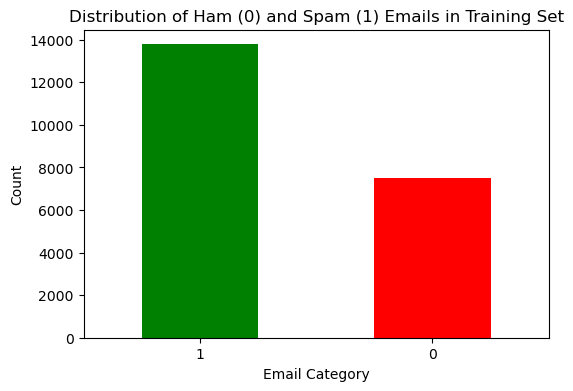

In [142]:
import email
import pandas as pd

# Function to clean the email body
def clean_email_body(message, stop_words):
    """
    Cleans an email message by:
    - Converting to lowercase
    - Removing HTML tags, punctuation, numbers, and escape sequences
    - Removing non-alphabetic characters
    - Removing stop words
    """
    message = message.lower()
    message = re.sub(html_tags_regex, '', message)  # Remove HTML tags
    message = message.translate(str.maketrans('', '', punctuation_chars))  # Remove punctuation
    message = message.translate(str.maketrans('', '', digit_chars))  # Remove numbers
    message = re.sub(escape_chars_regex, '', message)  # Remove escape sequences
    message = re.sub(r'[^a-zA-Z\s]', '', message)  # Remove non-alphabetic characters

    # Remove stop words
    words = message.split()
    cleaned_words = [word for word in words if word not in stop_words]

    return " ".join(cleaned_words)

# Function to extract plain text from emails
def extract_plain_text(parsed_email):
    """
    Extracts the plain text content from an email.
    - Handles multipart emails
    """
    if parsed_email.is_multipart():
        for part in parsed_email.walk():
            if part.get_content_type() == 'text/plain':
                return part.get_payload()
    else:
        return parsed_email.get_payload()
    return ""

# Initialize DataFrame to store the preprocessed emails
processed_emails_df = pd.DataFrame(columns=["folder", "file", "cleaned_text", "label"])

# Start processing
print("Email processing started...")

# Get list of folders in the dataset directory
folders = [folder for folder in os.listdir(folder_path) if not folder.startswith('.')]
print(f"Total {len(folders)} folders found.")

# Loop through each folder and process emails
for folder in folders:
    folder_path_full = f"{folder_path}/{folder}"
    files = [file for file in os.listdir(folder_path_full) if not file.startswith('.')]

    print(f"Processing folder: {folder} with {len(files)} files.")

    for file in files:
        file_path_full = f"{folder_path}/{folder}/{file}"
        
        # Read and parse each email
        with open(file_path_full, "r", encoding="ISO-8859-1") as email_file:
            raw_email = email_file.read()
            parsed_email = email.message_from_string(raw_email)
            message = extract_plain_text(parsed_email)
            
            # Clean the email body
            cleaned_message = clean_email_body(message, stopwords_set)
            
            # Get the label (ham/spam)
            label = email_labels_df[email_labels_df["file_path"] == f"{folder}/{file}"]["label"].values[0]
            
            # Append cleaned email and label to DataFrame
            processed_emails_df = pd.concat([processed_emails_df, pd.DataFrame([[folder, file, cleaned_message, label]],
                                                                               columns=["folder", "file", "cleaned_text", "label"])],
                                                                               ignore_index=True)

    print(f"Completed processing folder: {folder}")

# End processing
print("Email processing finished.")


# Change the CSV file names and folder names for saving processed data
processed_output_dir = "processed_data"
processed_output_file = f"{processed_output_dir}/processed_email_data.csv"

# Save the preprocessed data to a CSV file
if not os.path.exists(processed_output_dir):
    os.makedirs(processed_output_dir)

processed_emails_df.to_csv(processed_output_file, index=False)
print(f"Preprocessing complete. Data saved to {processed_output_file}.")

# Load the preprocessed dataset
preprocessed_data_df = pd.read_csv(processed_output_file)
print(f"Loaded {len(preprocessed_data_df)} preprocessed emails.")

# Split data into training (folders 0-70) and testing (folders 71-126)
train_data_df = preprocessed_data_df[preprocessed_data_df['folder'].astype(int) <= 70]
test_data_df = preprocessed_data_df[preprocessed_data_df['folder'].astype(int) > 70]

# Split training data into spam and ham categories
train_spam_df = train_data_df[train_data_df['label'] == 1]
train_ham_df = train_data_df[train_data_df['label'] == 0]

# Output dataset statistics
print(f"Training data: {len(train_data_df)} emails, {len(train_ham_df)} ham, {len(train_spam_df)} spam.")
print(f"Testing data: {len(test_data_df)} emails.")

# Visualize the distribution of spam and ham in the dataset
train_data_df['label'].value_counts().plot(kind='bar', color=['green', 'red'], figsize=(6, 4))
plt.title('Distribution of Ham (0) and Spam (1) Emails in Training Set')
plt.xlabel('Email Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


The cleaned email data is saved to a CSV file for future use.
The dataset is split into:
1. Training set (folders 0-70) for model training.
2. Test set (folders 71-126) for model testing.
The training set is further split into spam and ham categories for feature extraction.


### Feature Matrix

Counting word frequencies in the training set...
Top 10,000 words extracted. Example words: ['bb', 'will', 'board', 'company', 'price', 'gold', 'email', 'list', 'adobe', 'time']


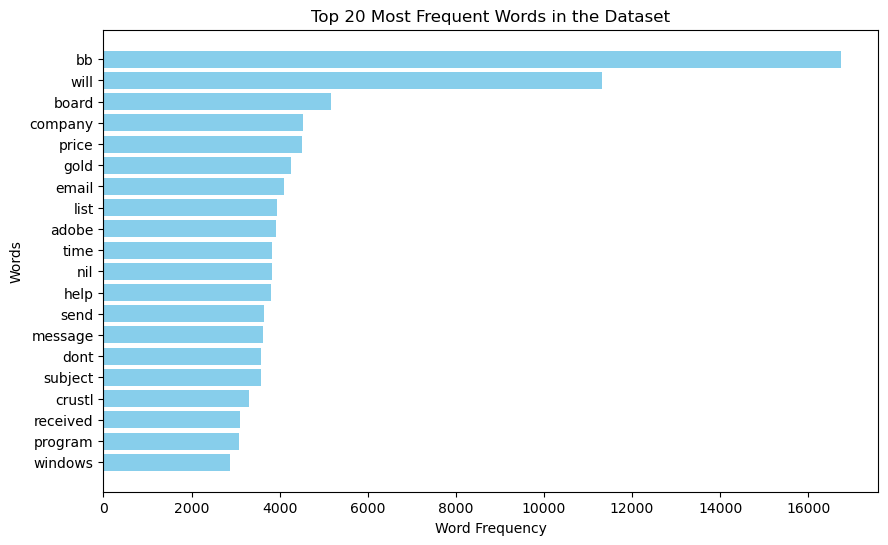

Generating feature matrices for ham and spam emails...
Ham Features Matrix shape: (7523, 10000)
Spam Features Matrix shape: (13777, 10000)


In [18]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# Function to filter words by a minimum occurrence threshold
def filter_frequent_words(word_counter, min_occurrence):
    """
    Filters out words that don't meet the minimum occurrence threshold.
    """
    return {word: count for word, count in word_counter.items() if count > min_occurrence}

# Function to generate the feature matrix from the email data
def generate_feature_matrix(dataframe, vocabulary, text_column='cleaned_text'):
    """
    Creates a binary feature matrix where each row corresponds to an email
    and each column represents the presence (1) or absence (0) of a word in the vocabulary.
    """
    # Create a mapping of each word in the vocabulary to an index
    word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
    
    # Initialize the feature matrix with zeros
    features_matrix = np.zeros((len(dataframe), len(vocabulary)), dtype=np.int32)

    # Populate the matrix with 1s where the word is present in the email
    for i, email_text in enumerate(dataframe[text_column].astype(str)):
        words_in_email = set(email_text.split())  # Using a set for faster lookup
        for word in words_in_email:
            if word in word_to_index:
                features_matrix[i, word_to_index[word]] = 1  # Mark the presence of the word
    
    return features_matrix

# Count word frequencies across all training emails
print("Counting word frequencies in the training set...")
word_count = Counter()
for email_text in train_data_df['cleaned_text'].astype(str):
    word_count.update(email_text.split())

# Filter the top 10,000 most common words
top_10000_words_dict = dict(word_count.most_common(10000))
top_10000_vocabulary = list(top_10000_words_dict.keys())
print(f"Top 10,000 words extracted. Example words: {top_10000_vocabulary[:10]}")

# Visualization: Show the top 20 most frequent words and their counts
top_words = list(top_10000_words_dict.keys())[:20]
top_word_counts = list(top_10000_words_dict.values())[:20]

plt.figure(figsize=(10, 6))
plt.barh(top_words[::-1], top_word_counts[::-1], color='skyblue')
plt.title('Top 20 Most Frequent Words in the Dataset')
plt.xlabel('Word Frequency')
plt.ylabel('Words')
plt.show()

# Create feature matrices for spam and ham emails
print("Generating feature matrices for ham and spam emails...")
ham_features_matrix = generate_feature_matrix(train_ham_df, top_10000_vocabulary)
spam_features_matrix = generate_feature_matrix(train_spam_df, top_10000_vocabulary)

# Output the shape of the feature matrices for progress
print(f"Ham Features Matrix shape: {ham_features_matrix.shape}")
print(f"Spam Features Matrix shape: {spam_features_matrix.shape}")


Feature matrices are created for spam and ham emails.

 Each email is converted into a vector of 0s and 1s, representing the presence or absence of the top 10,000 words.


### Computing the Priors

In [20]:
# Calculate the number of ham, spam, and total emails in the training set
num_ham_emails = len(train_ham_df)
num_spam_emails = len(train_spam_df)
num_total_emails = len(train_data_df)

# Calculate prior probabilities for ham and spam
prior_ham = num_ham_emails / num_total_emails
prior_spam = num_spam_emails / num_total_emails

# Output the prior probabilities
print(f"P(ham) = {prior_ham:.4f}, P(spam) = {prior_spam:.4f}")


P(ham) = 0.3532, P(spam) = 0.6468


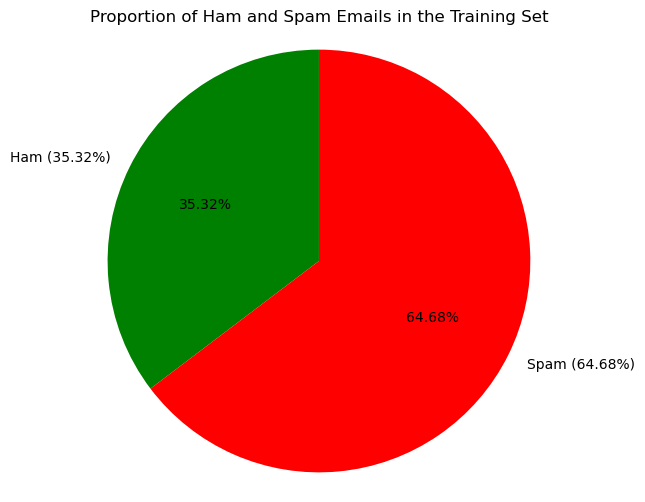

In [22]:
import matplotlib.pyplot as plt

# Data for visualization
labels = ['Ham (35.32%)', 'Spam (64.68%)']
sizes = [prior_ham, prior_spam]
colors = ['green', 'red']

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportion of Ham and Spam Emails in the Training Set')
plt.show()

### Compute Word Likelihoods with Laplace Smoothing

In [24]:
# Function to calculate word likelihoods with Laplace smoothing
def compute_likelihoods_laplace(feature_matrix, vocabulary_size, laplace_smoothing):
    """
    Calculates the likelihood of each word in the vocabulary using Laplace smoothing.
    
    Parameters:
    - feature_matrix: The binary matrix representing the presence of words in emails.
    - vocabulary_size: The number of unique words in the vocabulary.
    - laplace_smoothing: The smoothing parameter to avoid zero probabilities.
    
    Returns:
    - likelihoods: The likelihood of each word appearing in an email.
    """
    # Sum word occurrences across all emails in the matrix
    word_occurrences = np.sum(feature_matrix, axis=0)
    # Total occurrences of all words
    total_word_occurrences = np.sum(word_occurrences)
    # Calculate likelihoods using Laplace smoothing
    likelihoods = (word_occurrences + laplace_smoothing) / (total_word_occurrences + laplace_smoothing * vocabulary_size)
    return likelihoods

# Set the Laplace smoothing parameter
laplace_smoothing = 1.0
print("Calculating likelihoods with Laplace smoothing...")

# Calculate likelihoods for spam and ham emails
spam_likelihoods = compute_likelihoods_laplace(spam_features_matrix, len(top_10000_vocabulary), laplace_smoothing)
ham_likelihoods = compute_likelihoods_laplace(ham_features_matrix, len(top_10000_vocabulary), laplace_smoothing)

print("Likelihood calculation complete.")


Calculating likelihoods with Laplace smoothing...
Likelihood calculation complete.


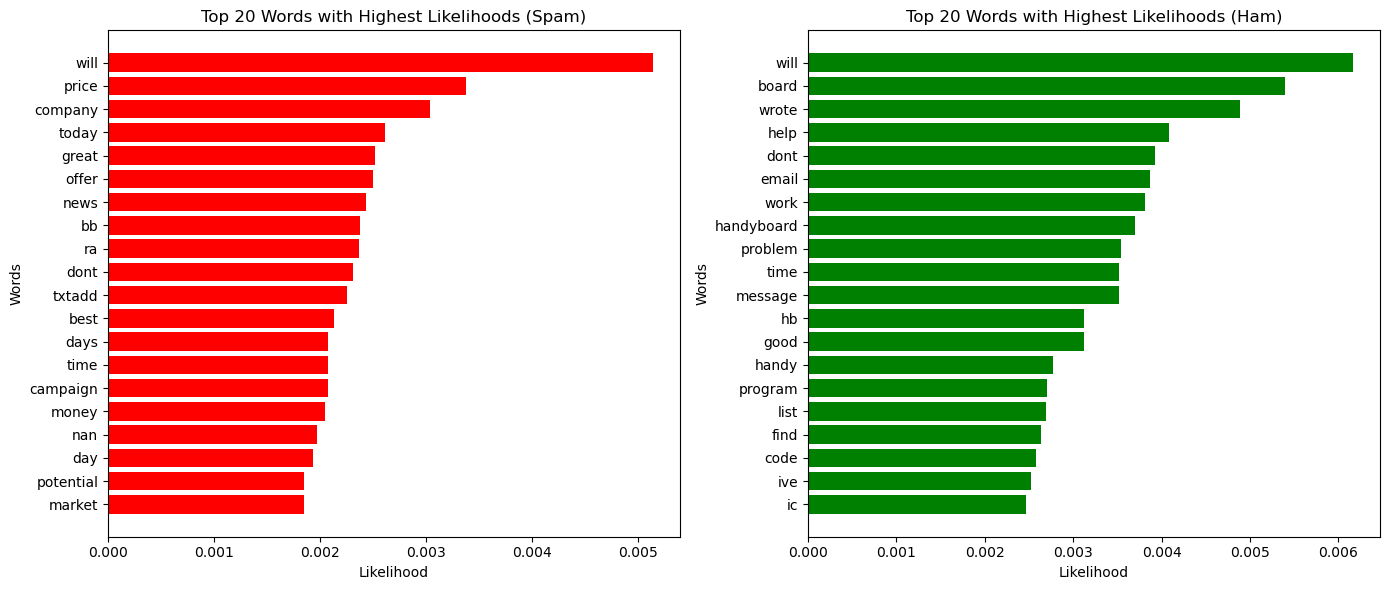

In [32]:
import matplotlib.pyplot as plt

# Select the top 20 words with the highest likelihoods for spam and ham
top_n = 20
top_spam_indices = np.argsort(spam_likelihoods)[-top_n:]  # Get indices of top spam likelihoods
top_ham_indices = np.argsort(ham_likelihoods)[-top_n:]    # Get indices of top ham likelihoods

top_spam_words = [top_10000_vocabulary[i] for i in top_spam_indices]
top_ham_words = [top_10000_vocabulary[i] for i in top_ham_indices]

top_spam_values = spam_likelihoods[top_spam_indices]
top_ham_values = ham_likelihoods[top_ham_indices]

# Plot top spam and ham likelihoods side by side
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(top_spam_words, top_spam_values, color='red')
plt.title('Top 20 Words with Highest Likelihoods (Spam)')
plt.xlabel('Likelihood')
plt.ylabel('Words')

plt.subplot(1, 2, 2)
plt.barh(top_ham_words, top_ham_values, color='green')
plt.title('Top 20 Words with Highest Likelihoods (Ham)')
plt.xlabel('Likelihood')
plt.ylabel('Words')

plt.tight_layout()
plt.show()


There is a clear distinction between the content of spam and ham emails. Spam emails tend to contain words related to promotions, offers, and commercial content, while ham emails have words associated with everyday communication, work, and collaboration.

### Classifying Emails

In [35]:
# Function to classify an email based on word likelihoods and prior probabilities
def predict_email_classification(email_content, spam_likelihoods, ham_likelihoods, prior_spam, prior_ham, vocabulary):
    """
    Classifies an email as spam (1) or ham (0) based on the Naive Bayes classification model.
    
    Parameters:
    - email_content: The text of the email to classify.
    - spam_likelihoods: The likelihoods of words appearing in spam emails.
    - ham_likelihoods: The likelihoods of words appearing in ham emails.
    - prior_spam: Prior probability of an email being spam.
    - prior_ham: Prior probability of an email being ham.
    - vocabulary: The list of the top 10,000 most common words.
    
    Returns:
    - 1 if classified as spam, otherwise 0 (ham).
    """
    # Initialize log probabilities for spam and ham
    log_prob_spam = np.log(prior_spam)
    log_prob_ham = np.log(prior_ham)

    # Tokenize the email content into words
    email_words = set(str(email_content).split())

    # Add the log likelihoods for each word present in the email
    for word in email_words:
        if word in vocabulary:
            word_index = vocabulary.index(word)
            log_prob_spam += np.log(spam_likelihoods[word_index])
            log_prob_ham += np.log(ham_likelihoods[word_index])

    # Return 1 if it's classified as spam, otherwise 0 (ham)
    return 1 if log_prob_spam > log_prob_ham else 0

# Classify training set emails safely using .loc
print("Classifying emails in the training set...")
train_data_df = train_data_df.copy()  # Ensure a copy to avoid SettingWithCopyWarning
train_data_df.loc[:, 'predicted_label'] = train_data_df['cleaned_text'].apply(
    lambda email: predict_email_classification(email, spam_likelihoods, ham_likelihoods, prior_spam, prior_ham, top_10000_vocabulary)
)
print("Classification completed for the training set.")

# Classify test set emails safely using .loc
print("Classifying emails in the test set...")
test_data_df = test_data_df.copy()  # Ensure a copy to avoid SettingWithCopyWarning
test_data_df.loc[:, 'predicted_label'] = test_data_df['cleaned_text'].apply(
    lambda email: predict_email_classification(email, spam_likelihoods, ham_likelihoods, prior_spam, prior_ham, top_10000_vocabulary)
)
print("Classification completed for the test set.")


Classifying emails in the training set...
Classification completed for the training set.
Classifying emails in the test set...
Classification completed for the test set.


In [47]:
print(test_data_df.columns)

Index(['folder', 'file', 'cleaned_text', 'label', 'predicted_label'], dtype='object')


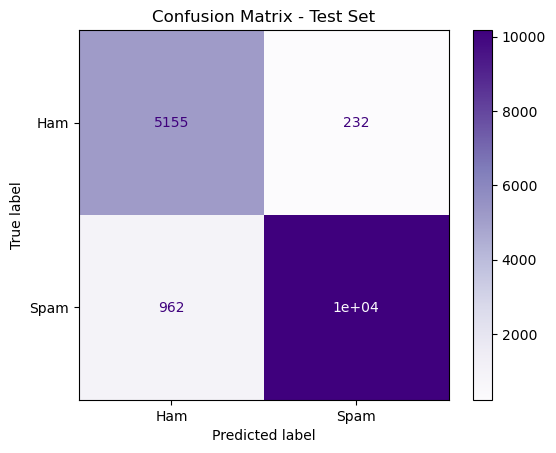

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix for the test set using the correct 'label' column
conf_matrix = confusion_matrix(test_data_df['label'], test_data_df['predicted_label'])

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Test Set')
plt.show()


True Positives (Spam classified as Spam):

The model correctly identified 10,000 spam emails.
True Negatives (Ham classified as Ham):

The model correctly classified 5,155 ham emails as non-spam (ham).
False Positives (Ham misclassified as Spam):

232 ham emails were incorrectly classified as spam, which represents false alarms where legitimate emails were flagged as spam.
False Negatives (Spam misclassified as Ham):

962 spam emails were incorrectly classified as ham, meaning these spam emails were not detected by the classifier.

True Positives and True Negatives: 
The model is correctly identifying most spam and ham emails, with a high number of true positives (spam correctly classified) and true negatives (ham correctly classified).

False Positives: 
The number of false positives is relatively low (232), meaning the model is doing a good job of avoiding flagging ham emails as spam.

False Negatives: The model missed identifying 962 spam emails, which is higher than false positives. This suggests that while the model is good at detecting spam, there are still some spam emails slipping through.

### Performance Evaluation

Evaluating the model...
Accuracy: 0.9277327200 (92.77%)
Precision: 0.9777030274 (97.77%)
Recall: 0.9136057476 (91.36%)
F1 Score: 0.9445682451 (94.46%)


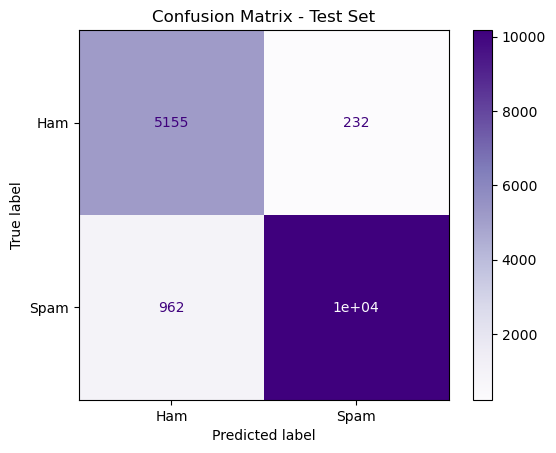

In [66]:
# Function to evaluate the model based on true and predicted labels
def evaluate_classification_model(dataframe, true_label_col, predicted_label_col):
    """
    Evaluates the classification model performance using the confusion matrix
    and calculates accuracy, precision, recall, and F1-score.
    
    Parameters:
    - dataframe: The DataFrame containing true and predicted labels.
    - true_label_col: The column with the actual labels (1 for spam, 0 for ham).
    - predicted_label_col: The column with the predicted labels (1 for spam, 0 for ham).
    """
    # Initialize counts for confusion matrix elements
    true_positive = false_positive = true_negative = false_negative = 0
    
    # Loop through each row to update confusion matrix counts
    for index, row in dataframe.iterrows():
        actual_label = int(row[true_label_col])  # 1 for spam, 0 for ham
        predicted_label = int(row[predicted_label_col])
        
        if predicted_label == 1 and actual_label == 1:
            true_positive += 1  # True Positive (correctly classified spam)
        elif predicted_label == 1 and actual_label == 0:
            false_positive += 1  # False Positive (misclassified ham)
        elif predicted_label == 0 and actual_label == 0:
            true_negative += 1  # True Negative (correctly classified ham)
        elif predicted_label == 0 and actual_label == 1:
            false_negative += 1  # False Negative (misclassified spam)

    # Calculate performance metrics
    accuracy = (true_negative + true_positive) / (true_negative + true_positive + false_positive + false_negative)
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics with 10 decimal places and percentage values
    print(f"Accuracy: {accuracy:.10f} ({accuracy * 100:.2f}%)")
    print(f"Precision: {precision:.10f} ({precision * 100:.2f}%)")
    print(f"Recall: {recall:.10f} ({recall * 100:.2f}%)")
    print(f"F1 Score: {f1_score:.10f} ({f1_score * 100:.2f}%)")
    
    return true_positive, false_positive, true_negative, false_negative

# Evaluate the model on the test set using the 'label' column (actual) and 'predicted_label' column (predicted)
print("Evaluating the model...")
tp, fp, tn, fn = evaluate_classification_model(test_data_df, 'label', 'predicted_label')

# Visualization: Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Create and visualize confusion matrix
conf_matrix = confusion_matrix(test_data_df['label'], test_data_df['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Purples)
plt.title('Confusion Matrix - Test Set')
plt.show()

# Results & Discussion

### 1. Effect of Removing Stop Words

We can compare the model performance with and without stop words. To do this, we'll run two separate experiments and compare the precision, recall, and accuracy.



      Metric  With Stop Words  Without Stop Words
0   Accuracy         0.927733            0.904612
1  Precision         0.977703            0.976188
2     Recall         0.913606            0.879928
3   F1 Score         0.944568            0.925562


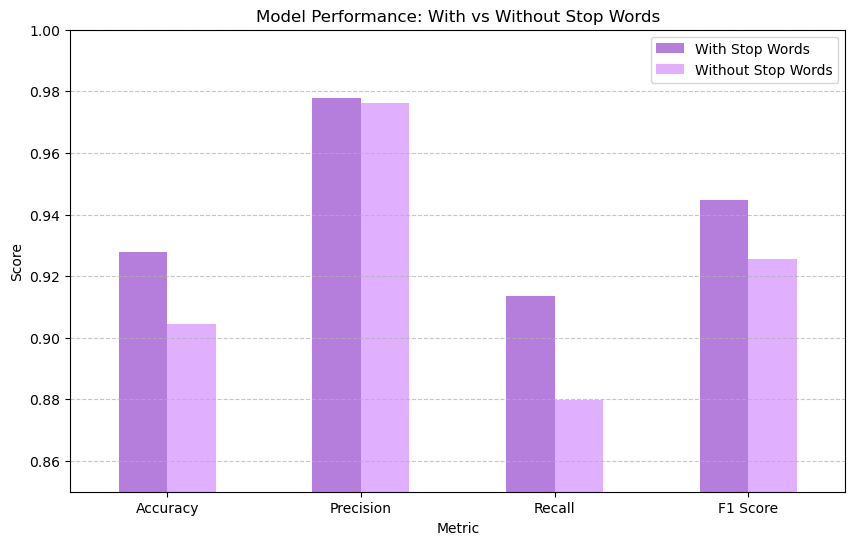

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the provided metrics
data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'With Stop Words': [0.9277327200, 0.9777030274, 0.9136057476, 0.9445682451],
    'Without Stop Words': [0.9046120324, 0.9761881040, 0.8799281545, 0.9255620631]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Plot the comparison
df.set_index('Metric').plot(kind='bar', figsize=(10, 6), color=['#b57edc', '#e0b0ff'])
plt.title('Model Performance: With vs Without Stop Words')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim([0.85, 1])  # Set y-axis range for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability
plt.show()


Including stop words improved the model's performance, especially in terms of accuracy, recall, and the F1 score. Accuracy dropped from 92.77% to 90.46% without stop words, and recall fell from 91.36% to 87.99%, indicating more missed spam emails. Precision remained nearly the same, showing stop words had little effect on correctly identifying spam. The F1 score decreased from 94.46% to 92.56%, reflecting an overall reduction in classification effectiveness without stop words. This suggests that stop words provide useful context in spam classification.

### 2. Experimenting with the number of words used for training by filtering the dictionary to include only words that occur more than certain thresholds (k > 100, k = 50 times).

Approach:
- We will adjust the minimum word occurrence threshold (k) and observe how the vocabulary size changes.
- Then, we will create feature matrices for these filtered vocabularies and evaluate the model's performance for each threshold.

Steps:
- Filter words based on frequency threshold (k).
- Create feature matrices for each threshold.
- Train and evaluate the model for each threshold and compare the results.
- Plot or tabulate the performance metrics.

Evaluating with vocabulary of words > 100 occurrences (unique)...
Evaluating with vocabulary of words > 50 occurrences (unique)...
      Metric  Words > 100  Words > 50
0   Accuracy     0.926099    0.655429
1  Precision     0.966497    0.731535
2     Recall     0.922317    0.772070
3   F1-Score     0.943890    0.751256


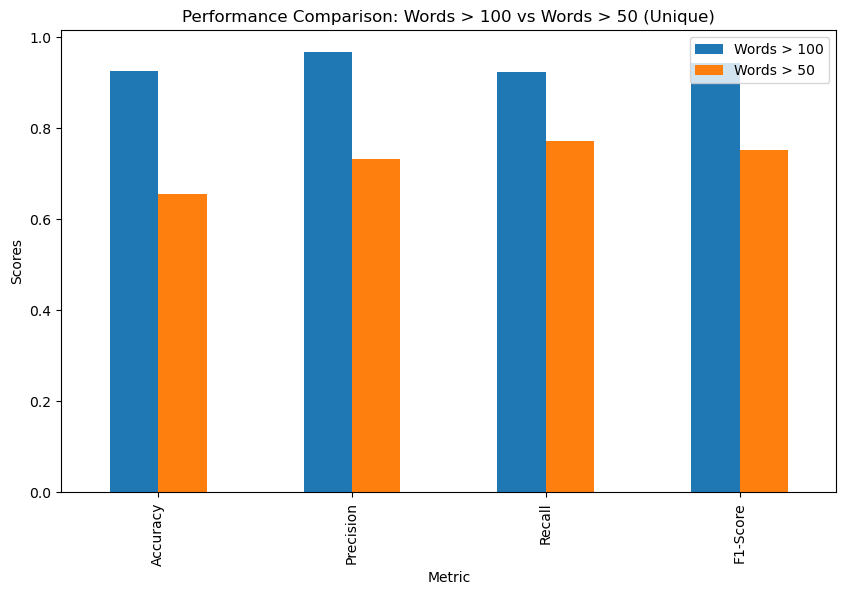

In [111]:
from collections import Counter

# Assuming word_count is a Counter containing the word frequencies in the dataset
# Let's limit to 1000 words for each dictionary

# Step 1: Filter words that appear more than 100 and 50 times
words_greater_than_100 = {word: count for word, count in word_count.items() if count > 100}
words_greater_than_50 = {word: count for word, count in word_count.items() if count > 50}

# Step 2: Ensure that the vocabularies are unique between the two dictionaries
# Remove words from words_greater_than_50 that are already in words_greater_than_100
words_greater_than_50_unique = {word: count for word, count in words_greater_than_50.items() if word not in words_greater_than_100}

# Step 3: Limit each dictionary to 1000 words (sorted by frequency)
vocab_100 = sorted(words_greater_than_100.keys(), key=lambda word: word_count[word], reverse=True)[:1000]
vocab_50 = sorted(words_greater_than_50_unique.keys(), key=lambda word: word_count[word], reverse=True)[:1000]

# Step 4: Function to filter and re-train the model using a specific vocabulary
def filter_and_train_with_vocab(vocab):
    # Recalculate likelihoods using the reduced vocabulary
    spam_likelihoods = compute_likelihoods_laplace(spam_features_matrix, len(vocab), laplace_smoothing)
    ham_likelihoods = compute_likelihoods_laplace(ham_features_matrix, len(vocab), laplace_smoothing)
    
    # Classify test set emails using the reduced vocabulary
    test_data_df['predicted_label'] = test_data_df['cleaned_text'].apply(
        lambda email: predict_email_classification(email, spam_likelihoods, ham_likelihoods, prior_spam, prior_ham, vocab)
    )
    
    # Evaluate performance
    accuracy, precision, recall, f1 = evaluate_and_print_metrics(test_data_df, 'label', 'predicted_label')
    return accuracy, precision, recall, f1

# Step 5: Evaluate with vocab > 100 occurrences (unique)
print("Evaluating with vocabulary of words > 100 occurrences (unique)...")
accuracy_100, precision_100, recall_100, f1_100 = filter_and_train_with_vocab(vocab_100)

# Step 6: Evaluate with vocab > 50 occurrences (unique and different from words > 100)
print("Evaluating with vocabulary of words > 50 occurrences (unique)...")
accuracy_50, precision_50, recall_50, f1_50 = filter_and_train_with_vocab(vocab_50)

# Step 7: Show a comparison table
import pandas as pd
results_dict_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Words > 100': [accuracy_100, precision_100, recall_100, f1_100],
    'Words > 50': [accuracy_50, precision_50, recall_50, f1_50]
})

print(results_dict_comparison)

# Step 8: Plot the results for visual comparison
results_dict_comparison.set_index('Metric').plot(kind='bar', figsize=(10, 6), title="Performance Comparison: Words > 100 vs Words > 50 (Unique)")
plt.ylabel('Scores')
plt.show()

Smaller, more frequent vocabulary (words > 100 occurrences) performs significantly better, maintaining higher accuracy and precision.

Expanding to less frequent words (words > 50 occurrences) introduces noise and reduces the model's performance across all metrics.

### 3. We will experiment with different values of λ (lambda) smoothing and observe how it affects the performance metrics such as accuracy, precision, recall, and F1 score.

Approach:
1. We will run the model with 5 different λ values: 2.0, 1.0, 0.5, 0.1, and 0.005.
2. For each λ, we will:
    - Recompute the word likelihoods with Laplace smoothing using the given λ.
    - Reclassify the emails using these new likelihoods.
    - Evaluate the model's performance.
3. We will then plot or tabulate the results for comparison.

In [112]:
# List of lambda values to experiment with
lambda_values = [2.0, 1.0, 0.5, 0.1, 0.005]
results_lambda = {}

for lambda_smoothing in lambda_values:
    print(f"\nRunning experiment with λ = {lambda_smoothing}...")
    
    # Recalculate likelihoods with the current lambda
    print(f"Calculating likelihoods with λ = {lambda_smoothing}...")
    spam_likelihoods_lambda = compute_likelihoods_laplace(spam_features_matrix, len(top_10000_vocabulary), lambda_smoothing)
    ham_likelihoods_lambda = compute_likelihoods_laplace(ham_features_matrix, len(top_10000_vocabulary), lambda_smoothing)
    
    # Classify test set
    print(f"Classifying test set with λ = {lambda_smoothing}...")
    test_data_df['predicted_label'] = test_data_df['cleaned_text'].apply(
        lambda email: predict_email_classification(email, spam_likelihoods_lambda, ham_likelihoods_lambda, prior_spam, prior_ham, top_10000_vocabulary)
    )
    
    # Evaluate the model performance
    print(f"Evaluating performance with λ = {lambda_smoothing}...")
    accuracy, precision, recall, f1_score = evaluate_and_print_metrics(test_data_df, 'label', 'predicted_label')
    
    # Store results for this λ value
    results_lambda[lambda_smoothing] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score
    }

# Convert the results into a DataFrame for easy viewing
results_lambda_df = pd.DataFrame(results_lambda).T
print("\nResults for varying λ values:")
print(results_lambda_df)


Running experiment with λ = 2.0...
Calculating likelihoods with λ = 2.0...
Classifying test set with λ = 2.0...
Evaluating performance with λ = 2.0...

Running experiment with λ = 1.0...
Calculating likelihoods with λ = 1.0...
Classifying test set with λ = 1.0...
Evaluating performance with λ = 1.0...

Running experiment with λ = 0.5...
Calculating likelihoods with λ = 0.5...
Classifying test set with λ = 0.5...
Evaluating performance with λ = 0.5...

Running experiment with λ = 0.1...
Calculating likelihoods with λ = 0.1...
Classifying test set with λ = 0.1...
Evaluating performance with λ = 0.1...

Running experiment with λ = 0.005...
Calculating likelihoods with λ = 0.005...
Classifying test set with λ = 0.005...
Evaluating performance with λ = 0.005...

Results for varying λ values:
       Accuracy  Precision    Recall  F1 Score
2.000  0.927188   0.977684  0.912797  0.944127
1.000  0.927733   0.977703  0.913606  0.944568
0.500  0.927672   0.977793  0.913426  0.944514
0.100  0.9274

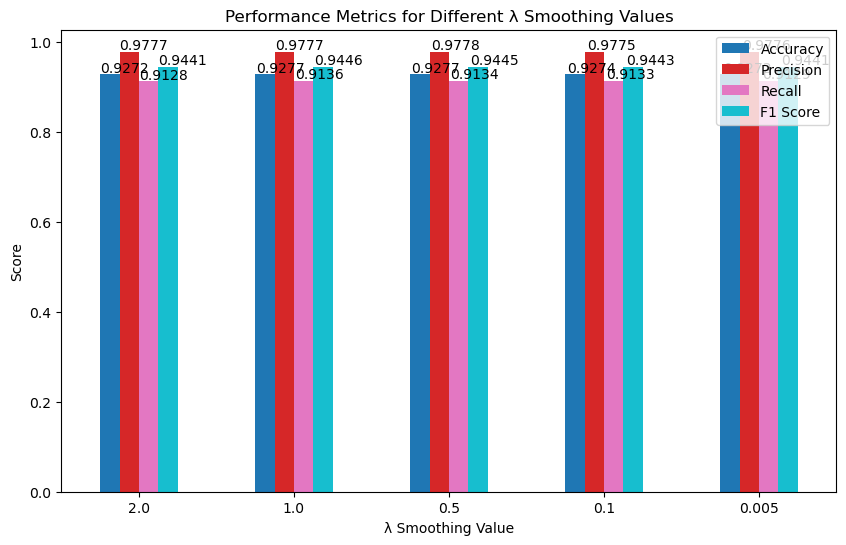

In [132]:
# Updated plot with a better colormap and value labels
ax = results_lambda_df.plot(kind='bar', figsize=(10, 6), colormap='tab10', rot=0)
plt.title('Performance Metrics for Different λ Smoothing Values')
plt.ylabel('Score')
plt.xlabel('λ Smoothing Value')

# Adding value labels to the bars for better visibility
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=10)

plt.show()


The experiments with varying lambda (λ) smoothing values show that the model's performance is generally stable across different λ values, with small variations. When λ is set to 1.0, the model achieves the highest overall performance, with 92.77% accuracy, 97.77% precision, and 91.36% recall, resulting in an optimal F1-score of 94.46%. This suggests that the balance between precision and recall is best at this value. While reducing λ to 0.5 or 0.1 produces similar results, there is a slight decline in both accuracy and F1-score. The highest λ value of 2.0 also performs well but is marginally less effective than λ = 1.0 in terms of recall and F1-score. In contrast, extremely low λ values like 0.005 show a minor decrease in overall performance. 

Therefore, λ = 1.0 is recommended as the optimal smoothing value for maintaining the best balance between precision, recall, and overall classification performance.

### 4. Recommendations

1. For Feature Selection, we observed that using the top 10,000 most common words works well, but it might still include irrelevant or noisy features. We could reduce the size of the vocabulary by filtering out words that occur too frequently (such as stop words) or too rarely (words that appear only once or twice).

    We can try different thresholds for minimum and maximum word occurrences to determine an optimal vocabulary size (e.g., words appearing more than 50 times but less than 1,000 times).

2. Using N-grams. In emails, instead of just using single words (unigrams), we can try incorporating bigrams (pairs of consecutive words) or even trigrams. This can help capture word sequences like "free offer" or "click here" which are more indicative of spam. We can expand the feature matrix to include bigrams or trigrams.

3. Handling Imbalanced Datasets. I noticed that if the dataset is heavily skewed toward one class (e.g., more spam emails than ham emails), this can heavily affect the model's performance. With this, we can do:
    - Resampling. Either oversample the minority class (ham) or undersample the majority class (spam) to create a more balanced dataset.
    - Class Weights. Adjust the Naive Bayes algorithm to give more weight to the minority class, which could help improve precision and recall for ham emails.
  
4. Having alternative smoothing techniques. I experimented with different λ values in Laplace smoothing, but we can also explore other smoothing techniques such as Dirichlet smoothing or Good-Turing smoothing, which may perform better depending on the dataset.

5. Advanced Preprocessing Techniques. The preprocessing part gave me a hard time in doing so, but I realized that this heavily affects the model's performance and results. For this, we can use Stemming/Lemmatization. By reducing the vocabulary size, we could implement stemming (reducing words to their root form, e.g., "running" → "run") or lemmatization (converting words to their base form, e.g., "was" → "be"). This could reduce redundancy and improve generalization.

6. Exploring alternative algorithms is also another way to improve as we consider alternative classifiers. While Naive Bayes is simple and fast, experimenting with other machine learning algorithms such as Logistic Regression, Support Vector Machines (SVMs), or Random Forests could yield better results.